# RAMP: Predicting volcanic events from Tephrochronology of the Southern and Austral Volcanic Zones of the Andes
*Consuelo Martinez, Chiara Marmo, Guillaume Delpech (GEOPS, UPS), François Caud (DATAIA, UPS)*

<div>
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td align="left"; style="background-color:transparent; width: 40%;">
        <a href="https://dataia.eu">
            <img src="https://github.com/ramp-kits/tephra/raw/main/img/DATAIA-h.png" width="450px"/>
        </a>
    </td>
    <td align="right"; style="background-color:transparent; width: 40%;">
        <a href="https://www.geops.universite-paris-saclay.fr/">
            <img src="https://github.com/ramp-kits/tephra/raw/main/img/LOGO-GEOPS-2020-1024x488-1.jpg" width="350px"/>
        </a>
    </td>
  </tr>
 </table>
</div>



## Table of Contents
* [Introduction](#introduction)
* [The dataset](#dataset)
* [Data exploration](#exploration)
* [Requirements](#requirements)
* [Base model](#base_model)
* [Submitting on RAMP](#submitting)

## Introduction <a class="anchor" id="introduction"></a>
Tephrochronology is the discipline of geosciences which uses the deposits of explosive volcanic eruptions
as stratigraphic and chronological markers.
By identifying the pyroclastic remains of specific eruptions (tephras) in different sites, tephrochronology helps reconstruct the eruptive history of volcanic centers: the magnitude of their eruptions, their recurrence in time and the dispersion of its products.
Also, tephras can be viewed as regional stratigraphic tie points.
If a specific tephra is identified in different paleoenvironmental archives (e.g. paleoclimatological, paleoceanographic, archaeological), their chronologies can be synchronized, which is essential when interpreting the evolution of complex systems in time, such as the climate.

The Southern (SVZ, 33–46° S) and Austral (AVZ, 49–55° S) volcanic Zones of the Andes are two very active
volcanic zones, where so far around 65 volcanic centers have been identified which have had recurrent
explosive activity in historical times or during the last 20,000 years.
In these regions, tephrochronology has a great potential of use, for example by helping reconstruct the eruptive history of these volcanic centers, essential in the production of volcanic hazard maps.
In the last four decades, tephrochronology together with volcanology have importantly increased our
understanding of the eruptive history of the SVZ and AVZ, revealing higher recurrence and explosivity of
many volcanic centers than previously thought.
It has also become apparent that there are still many under researched active volcanic centers in the area for
which no eruptions have been robustly identified yet.
Disentangling this intricate record is hampered by the very similar geochemical composition of the products of many volcanic centers, which makes it difficult to identify their source; additionally, the high uncertainties associated
with the age estimates of the tephra deposits further hinders their correlations.

The original dataset contains tephrochronological and volcanological information on 32 active volcanic centers from the
SVZ and AVZ, collected from seventy-three scientific publications published in peer reviewed journals, six publications from [SERNAGEOMIN](https://www.sernageomin.cl/), and two doctoral theses.
These correspond to 130 different eruptive events and 16,500 sample analyses.
The data were obtained either directly from the publication tables, text and supplementary material, or alternatively through private requests to the authors when the data discussed in the publication was not readily available.

The goal of the data challenge is to predict the volcanic eruption (event) using the geochemical composition of the tephras.

## The dataset <a class="anchor" id="dataset"></a>
The description of all the columns of the dataset is available from [Martinez PhD Thesis](https://theses.hal.science/tel-03543983/document#page=84)

| ![dataset_structure.png](https://github.com/ramp-kits/tephra/raw/main/img/dataset_structure.png) |
|:--:|
| <b>Dataset structure, using information from sample LAZ-T7A (Alloway et al. 2017b) as an example. The Flag and comment attributes are not illustrated</b>|

For this challenge, the data were first preprocessed and then split in order to preserve a private test set on which to evaluate the models on our servers. This leaves 6220 observations in the public train set and 839 observations in the public test set. 
Observations are grouped in samples (with a SampleID each) and we are very cautious to keep those examples from the same sample either in the train set or in the test set (both during splitting (see point 4. of preprocess) and cross-validation).

Preprocessing steps before splitting the data:
1.  We dropped rows corresponding to samples not analyzed for geochemistry, as well as outliers, samples for which the volcanic source is uncertain, and samples with Analytical Totals lower than 94 wt.%, as they might correspond to altered samples.

2.  We replaced some values in the dataset: 
    - Replace element concentrations registered as "0" with "below detection limit" (bdl). Because a value equal to zero is not possible to determine with the current analytical techniques, thus bdl is more accurate.
    -  Replace the various missing values placeholders by np.nan
    -  Make sure major and trace elements correspond to numbers and not strings.

3. Because Fe can be analyzed in different states (FeO, Fe2O3, FeOT, Fe2O3T), the columns describing Fe have many missing values but which can be filled by transforming one form of Fe into another. Because most of the samples in the BOOM dataset have been analyzed by Electron microscopy which analyzes Fe as FeOT, we calculate FeOT for all the samples and drop the other rows (Fe2O3, Fe2O3T, FeO) as they are redundant.

4. We checked if there was any event with observations from only one sample (SampleID) and removed them. 

5. We dropped the events with too few observations.

## Requirements <a class="anchor" id="requirements"></a>

In [46]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Download Data

In [5]:
# Uncomment the following line to download data:
!python download_data.py

Checking the data URL...Ok.
100%|████████████████████████████████████| 883k/883k [00:00<00:00, 11.8Mbytes/s]
Extracting now...Ok.
Removing the archive...Ok.
Checking the data...Ok.


## Data Exploration <a class="anchor" id="exploration"></a>

### Training data 

Here we load the whole .csv file but we will select only the geochemical variables in order to train models for this challenge.

In [12]:
train_df = pd.read_csv('./data/train.csv')
train_df

,Volcano,Event,Magnitude,VEI,SampleID,SampleObservationID,IGSN,Location,Latitude,Longitude,...,La_Yb,Zr_Nb,Sr87_Sr86,Sr87_Sr86_2SE,Nd143_Nd144,Nd143_Nd144_2SE,MeasurementRun,Comments,Flag,FlagDescription
0,Puyehue-Cordón Caulle,PCC2011,5.0,NaN,PCC-1,13-19-1-01,NaN,"Bariloche (BSI), km 7.600",-41.130000,-71.401777,...,5.576923,38.125000,NaN,NaN,NaN,NaN,AllowayMay2014,NaN,NaN,NaN
1,Puyehue-Cordón Caulle,PCC2011,5.0,NaN,PCC-1,13-19-1-02,NaN,"Bariloche (BSI), km 7.600",-41.130000,-71.401777,...,4.892183,34.274194,NaN,NaN,NaN,NaN,AllowayMay2014,NaN,NaN,NaN
2,Puyehue-Cordón Caulle,PCC2011,5.0,NaN,PCC-1,13-19-1-03,NaN,"Bariloche (BSI), km 7.600",-41.130000,-71.401777,...,4.353741,41.363636,NaN,NaN,NaN,NaN,AllowayMay2014,NaN,NaN,NaN
3,Puyehue-Cordón Caulle,PCC2011,5.0,NaN,PCC-1,13-19-1-06,NaN,"Bariloche (BSI), km 7.600",-41.130000,-71.401777,...,5.617284,35.130435,NaN,NaN,NaN,NaN,AllowayMay2014,NaN,NaN,NaN
4,Puyehue-Cordón Caulle,PCC2011,5.0,NaN,PCC-1,13-19-1-07,NaN,"Bariloche (BSI), km 7.600",-41.130000,-71.401777,...,5.284431,37.477477,NaN,NaN,NaN,NaN,AllowayMay2014,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6215,Chaitén,Vcha-2008,NaN,NaN,Cha 2008,G5e-5,NaN,NaN,-42.810000,-72.690000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Geochemistry_Issue,The original analytical total was not publishe...
6216,Chaitén,Vcha-2008,NaN,NaN,Cha 2008,G5e-6,NaN,NaN,-42.810000,-72.690000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Geochemistry_Issue,The original analytical total was not publishe...
6217,Chaitén,Vcha-2008,NaN,NaN,Cha 2008,G5e-7,NaN,NaN,-42.810000,-72.690000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Geochemistry_Issue,The original analytical total was not publishe...
6218,Chaitén,Vcha-2008,NaN,NaN,Cha 2008,G5e-8,NaN,NaN,-42.810000,-72.690000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Geochemistry_Issue,The original analytical total was not publishe...


In [13]:
test_df = pd.read_csv('./data/test.csv')
test_df

,Volcano,Event,Magnitude,VEI,SampleID,SampleObservationID,IGSN,Location,Latitude,Longitude,...,La_Yb,Zr_Nb,Sr87_Sr86,Sr87_Sr86_2SE,Nd143_Nd144,Nd143_Nd144_2SE,MeasurementRun,Comments,Flag,FlagDescription
0,Puyehue-Cordón Caulle,PCC2011,5.0,NaN,PCC-10 (2),PCC-10 (2),NaN,Villa Traful,-40.595329,-71.384650,...,5.152778,32.974773,NaN,NaN,NaN,NaN,AllowaySOLICPMS2015,NaN,SampleID_Issue,A specific SampleID is not provided in the pub...
1,Puyehue-Cordón Caulle,PCC2011,5.0,NaN,PCC-19 (2),PCC-19 (2),NaN,"National Route 40, Villa Llanquin",-40.880955,-71.016003,...,5.313993,34.827795,NaN,NaN,NaN,NaN,AllowaySOLICPMS2015,NaN,SampleID_Issue,A specific SampleID is not provided in the pub...
2,Puyehue-Cordón Caulle,PCC2011,5.0,NaN,PCC-20,PCC-20_10,NaN,"National Route 40, Confluencia",-40.670264,-71.062683,...,NaN,NaN,NaN,NaN,NaN,NaN,"25th August, 2013",NaN,Geochemistry_Issue,The data is published normalized in the origin...
3,Puyehue-Cordón Caulle,PCC2011,5.0,NaN,PCC-20,PCC-20_11,NaN,"National Route 40, Confluencia",-40.670264,-71.062683,...,NaN,NaN,NaN,NaN,NaN,NaN,"25th August, 2013",NaN,Geochemistry_Issue,The data is published normalized in the origin...
4,Puyehue-Cordón Caulle,PCC2011,5.0,NaN,PCC-20,PCC-20_12,NaN,"National Route 40, Confluencia",-40.670264,-71.062683,...,NaN,NaN,NaN,NaN,NaN,NaN,"25th August, 2013",NaN,Geochemistry_Issue,The data is published normalized in the origin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,Reclus,R1,NaN,5.0,90-02,90-02,NaN,Río Tres Brazos,-53.600000,-71.033333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stern et al. (2008) estimate the erupted volum...,NaN,NaN
835,Reclus,R1,NaN,5.0,90-05,90-05,NaN,Pampa Alegre (Rio Seco),-53.066667,-70.850000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stern et al. (2008) estimate the erupted volum...,NaN,NaN
836,Reclus,R1,NaN,5.0,90-06,90-06,NaN,Pampa Alegre (Rio Seco),-53.066667,-70.850000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stern et al. (2008) estimate the erupted volum...,NaN,NaN
837,Reclus,R1,NaN,5.0,CS-102,CS-102,NaN,Cabo Boquerón,-53.466667,-70.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Stern et al. (2008) estimate the erupted volum...,NaN,NaN


In [15]:
train_df.columns

Index(['Volcano', 'Event', 'Magnitude', 'VEI', 'SampleID',
       'SampleObservationID', 'IGSN', 'Location', 'Latitude', 'Longitude',
       'Authors', 'DOI', 'TypeOfRegister', 'TypeOfAnalysis',
       'AnalyzedMaterial', 'AnalyticalTechnique', 'TypeOfSection', 'SectionID',
       'SubSectionID', 'SubSection_DistanceFromTop_cm', 'HistoricalAge',
       'RadiocarbonAge', 'RadiocarbonAgeError', 'RadiocarbonLabCode',
       'StratigraphicPosition', 'Ar40Ar39_Age', 'Ar40Ar39_Age_Error',
       'DepositColor', 'DepositThickness_cm', 'GrainSize_min', 'GrainSize_max',
       'SiO2', 'TiO2', 'Al2O3', 'FeO', 'Fe2O3', 'Fe2O3T', 'FeOT', 'MnO', 'MgO',
       'CaO', 'Na2O', 'K2O', 'P2O5', 'Cl', 'LOI', 'Total', 'SiO2_normalized',
       'TiO2_normalized', 'Al2O3_normalized', 'FeOT_normalized',
       'MnO_normalized', 'MgO_normalized', 'CaO_normalized', 'Na2O_normalized',
       'K2O_normalized', 'P2O5_normalized', 'Cl_normalized',
       'Total_normalization', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Cs', 'Ba

<AxesSubplot:>

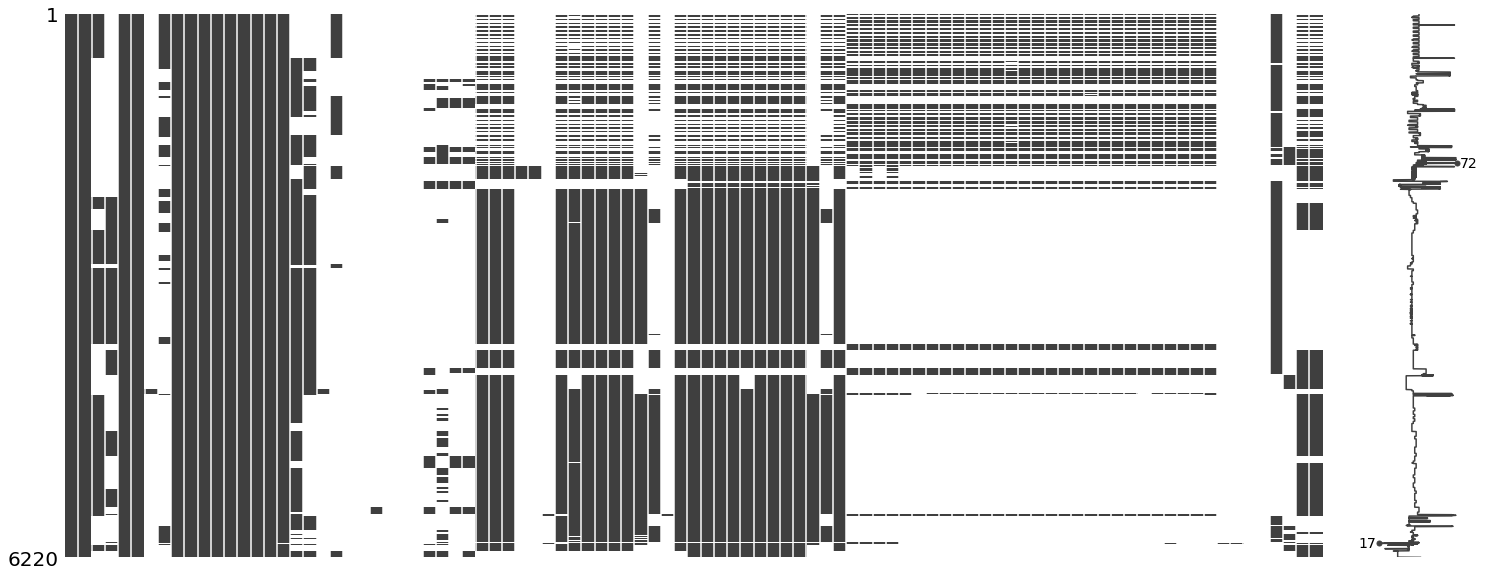

In [17]:
# Missingness

msno.matrix(train_df)

## Labels
The target variable is in the column Event since we classify volcanic events.

In [39]:
train_df.Event.unique().shape, train_df.Event.unique()

((30,),
 array(['PCC2011', 'Cha1', 'Grande', 'Vcha-2008', 'Vilcún', 'Lepué',
        '1852 Llaima', 'HW3', 'H1', 'MB1', 'R1', 'Achen', 'Llaima Pumice',
        'Arauco', 'Enco', 'Hua-hum', 'Neltume', 'Mil Hojas', 'PCC2',
        'Ranco', 'Puesco', 'Quet1', 'Pucón', 'Playas Blanca-Negra',
        'La Junta', 'HW6', 'Huilo', 'MC12', 'Pirehueico', 'Riñihue'],
       dtype=object))

There are 30 events to classify examples from.

In [22]:
train_df.Event.value_counts(dropna=False)

PCC2011                567
Vcha-2008              521
Neltume                407
Cha1                   391
Puesco                 389
Mil Hojas              318
Enco                   313
Lepué                  299
La Junta               292
Pucón                  227
Arauco                 218
Pirehueico             210
Llaima Pumice          179
Ranco                  177
Huilo                  167
H1                     158
1852 Llaima            150
MC12                   141
Hua-hum                140
Vilcún                 116
Grande                 115
Achen                   95
Riñihue                 89
MB1                     86
R1                      81
PCC2                    77
Playas Blanca-Negra     77
HW6                     77
HW3                     76
Quet1                   67
Name: Event, dtype: int64

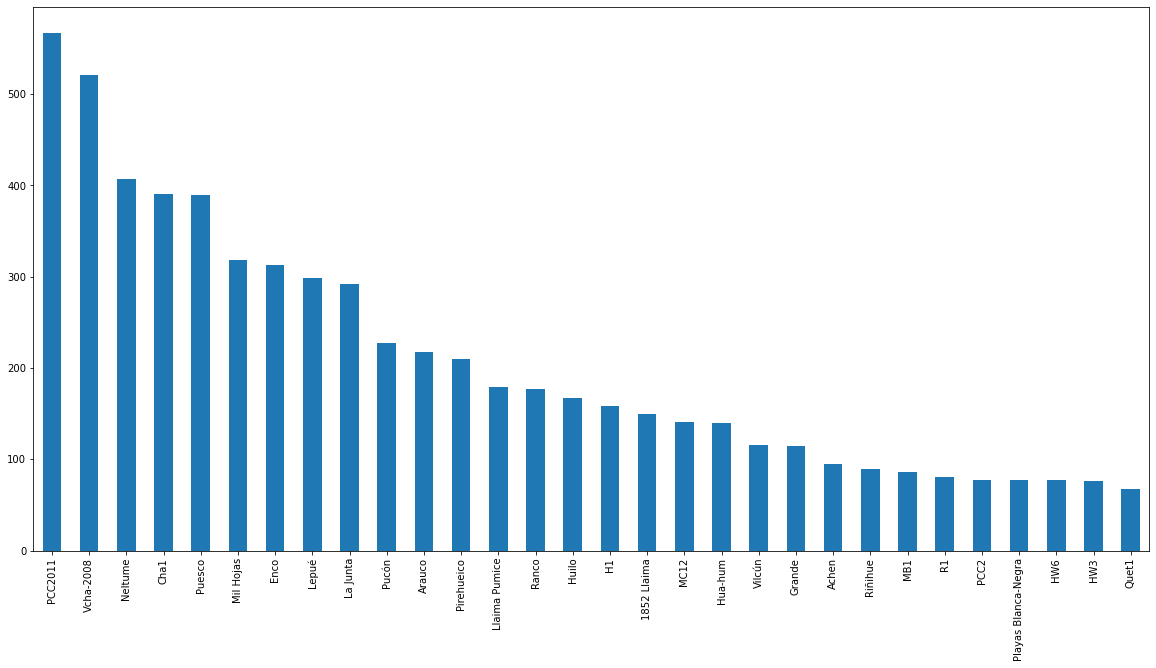

In [23]:
ax_pub = train_df.Event.value_counts(normalize=False).plot(kind='bar', figsize=(20, 10))

You can see that we deal with an imbalanced dataset, where some classes have  almost 10 times more observations than others. 

### Sample groups

In [40]:
# Distribution of groups in each class
group_class_counts = train_df.groupby(['Event', 'SampleID']).size().unstack(fill_value=0)
group_class_counts

SampleID,"0201DT8, 1804 cm",020300-1,020300-2B,030114-1,030114-4,040114-2B,040114-2C,040300-1D,040300-2C,070114-8C,...,T-24,T6/98,T8/100,Trevelín3-08-05-2008,VILL1C-II-55,VILLAR1B-I-91,VILLAR1B-II-38.5,VILLAR1C-I-119,VILLAR1C-II-37,psC-5
Event,,,,,,,,,,,,,,,,,,,,,
1852 Llaima,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Achen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Arauco,0,0,0,0,0,0,0,0,27,29,...,0,0,0,0,0,0,0,0,0,0
Cha1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Enco,0,0,32,0,0,0,0,40,0,0,...,0,0,0,0,0,0,0,0,0,0
Grande,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21
H1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HW3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HW6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


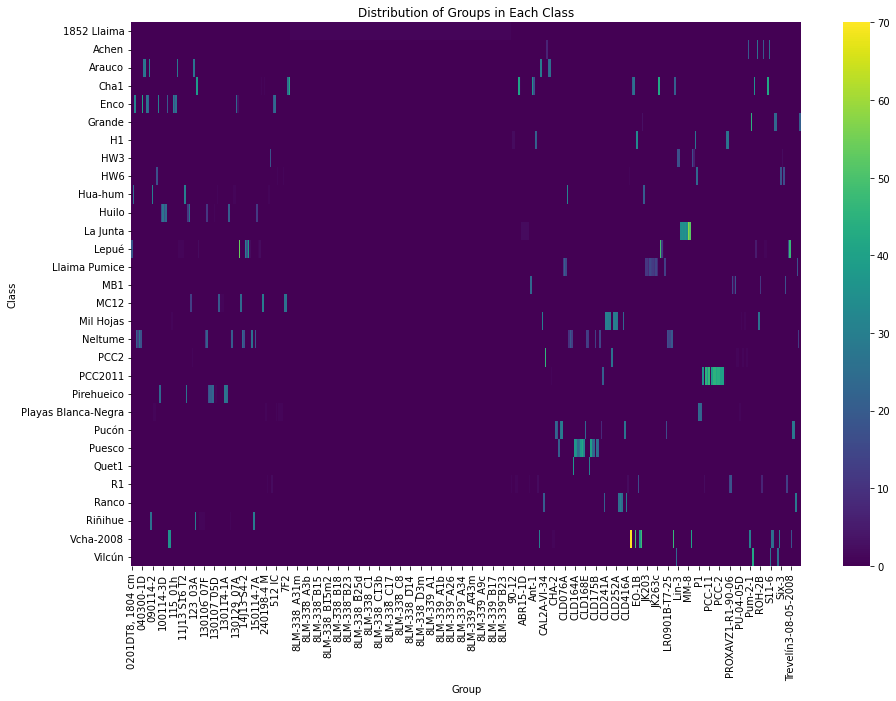

In [42]:
# heatmap of the distribution of groups in each class
plt.figure(figsize=(15, 10))
sns.heatmap(group_class_counts, cmap="viridis")
plt.title('Distribution of Groups in Each Class')
plt.xlabel('Group')
plt.ylabel('Class')
plt.show()

## Base model <a class="anchor" id="base_model"></a>

### We only keep geochemical data

In [26]:
# Retrieve the geochemical data. FeO, Fe2O3 and FeO2O3T are dropped because
# FeOT is a different expression of the same element (Fe).
# P2O5 and Cl are also dropped because they are sporadically analyzed.
majors = ['SiO2_normalized', 'TiO2_normalized', 'Al2O3_normalized',
          'FeOT_normalized',
          # 'FeO_normalized', 'Fe2O3_normalized', 'Fe2O3T_normalized',
          'MnO_normalized', 'MgO_normalized', 'CaO_normalized',
          'Na2O_normalized', 'K2O_normalized',
          # 'P2O5_normalized','Cl_normalized'
          ]
traces = ['Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Cs', 'Ba', 'La',
          'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy',
          'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'Pb',
          'Th', 'U']

In [31]:
X_majors_train = train_df.loc[:, majors]
X_traces_train = train_df.loc[:, traces]
X_train_df = pd.concat([X_majors_train, X_traces_train], axis=1)

In [32]:
X_train_df

,SiO2_normalized,TiO2_normalized,Al2O3_normalized,FeOT_normalized,MnO_normalized,MgO_normalized,CaO_normalized,Na2O_normalized,K2O_normalized,Rb,...,Ho,Er,Tm,Yb,Lu,Hf,Ta,Pb,Th,U
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.000000,...,2.170000,6.86000,1.170000,6.760000,1.330000,12.600000,0.756,36.10000,10.900000,3.00000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.000000,...,2.440000,6.73000,0.952000,7.420000,0.971000,11.600000,0.828,43.40000,11.100000,2.90000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.400000,...,2.790000,7.84000,1.190000,8.820000,1.400000,13.700000,0.691,37.00000,11.900000,2.89000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.900000,...,2.260000,7.67000,0.943000,6.480000,1.490000,11.900000,0.559,45.00000,10.500000,3.27000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.100000,...,2.220000,7.18000,1.420000,6.680000,0.940000,10.700000,0.725,49.00000,10.100000,2.74000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6215,75.550683,0.124652,14.134401,1.236851,0.103793,0.272280,1.395362,4.004196,3.177781,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6216,75.298120,0.163281,14.389786,1.382133,0.083662,0.256138,1.398704,3.897638,3.130538,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6217,75.636943,0.104154,14.038277,1.331270,0.067500,0.220927,1.328066,4.052097,3.220767,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6218,75.380973,0.164384,13.996524,1.493424,0.026216,0.388185,1.447166,3.920314,3.182813,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

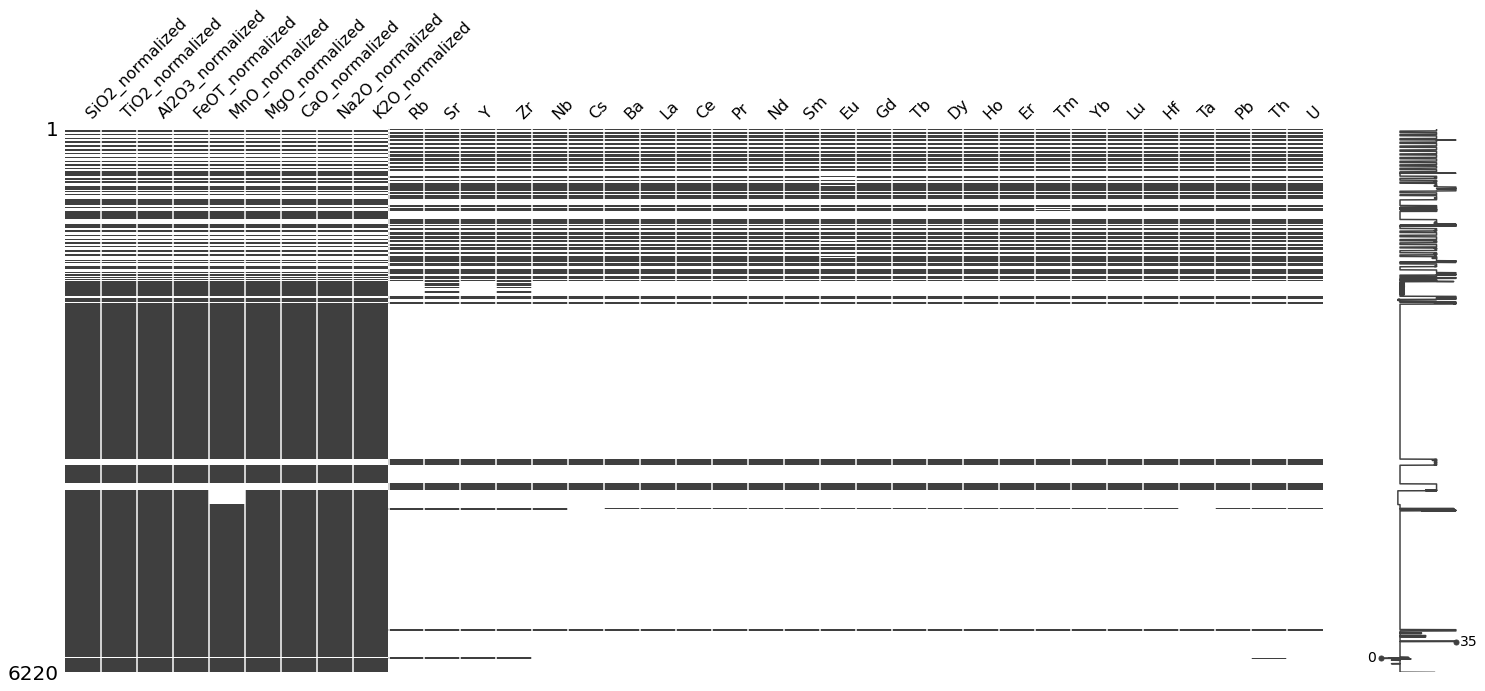

In [33]:
msno.matrix(X_train_df)

We have to tackle missingness even on this 35 variables data.


In [34]:
X_majors_test = test_df.loc[:, majors]
X_traces_test = test_df.loc[:, traces]
X_test_df = pd.concat([X_majors_test, X_traces_test], axis=1)

In [35]:
X_test_df

,SiO2_normalized,TiO2_normalized,Al2O3_normalized,FeOT_normalized,MnO_normalized,MgO_normalized,CaO_normalized,Na2O_normalized,K2O_normalized,Rb,...,Ho,Er,Tm,Yb,Lu,Hf,Ta,Pb,Th,U
0,68.271754,0.908540,14.445790,4.885928,0.131234,0.868161,2.543913,5.148395,2.634767,69.21,...,1.87,5.62,0.86,5.76,0.87,8.430000,0.620000,25.77,8.57,2.28
1,69.767911,0.706357,14.238143,4.177598,0.121090,0.655903,2.189707,5.216953,2.785066,73.31,...,1.92,5.80,0.87,5.86,0.89,8.810000,0.570000,26.22,8.78,2.20
2,71.652835,0.579942,14.408559,3.709629,0.089991,0.539946,1.629837,4.259574,2.939706,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,71.552845,0.589941,14.538546,3.949605,0.119988,0.529947,1.669833,4.109589,2.769723,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,71.780000,0.560000,14.270000,3.800000,0.050000,0.510000,1.630000,4.390000,2.870000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

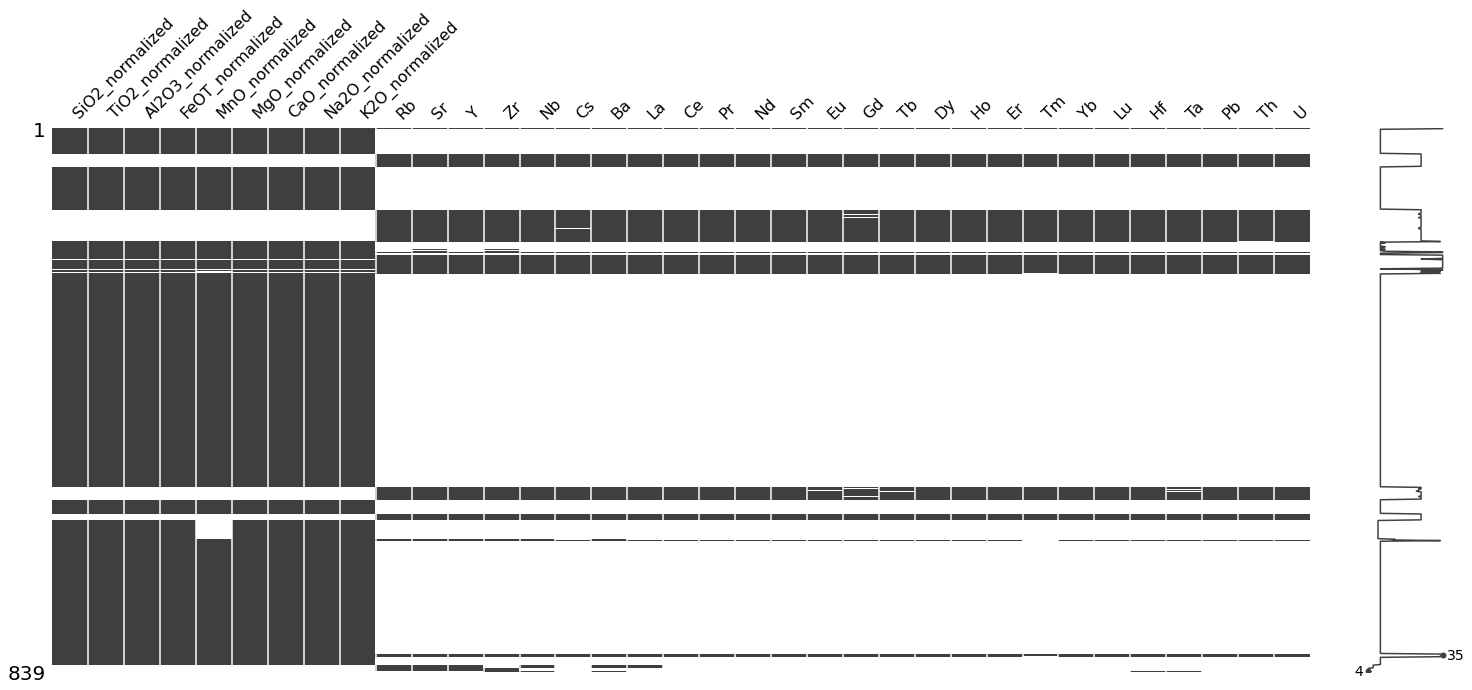

In [36]:
msno.matrix(X_test_df)

The model will take numpy arrays as input.

In [30]:
X_train = X_train_df.to_numpy()
X_train

array([[        nan,         nan,         nan, ..., 36.1       ,
        10.9       ,  3.        ],
       [        nan,         nan,         nan, ..., 43.4       ,
        11.1       ,  2.9       ],
       [        nan,         nan,         nan, ..., 37.        ,
        11.9       ,  2.89      ],
       ...,
       [75.63694268,  0.10415415, 14.03827665, ...,         nan,
                nan,         nan],
       [75.38097296,  0.16438395, 13.99652405, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,  9.04441963,
         4.26585366,  0.99751983]])

In [37]:
X_test = X_test_df.to_numpy()
X_test

array([[68.27175449,  0.90854028, 14.44579043, ..., 25.77      ,
         8.57      ,  2.28      ],
       [69.7679112 ,  0.70635722, 14.23814329, ..., 26.22      ,
         8.78      ,  2.2       ],
       [71.65283472,  0.57994201, 14.40855914, ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

Labels for the train and test sets.
We use a dictionary to store the correspondence between categories and integer labels for this dataset.

In [43]:
# Hard code int_to_cat dict and retrieve cat_to_int with dictionary comprehension to use in all needed files
int_to_cat = {
    0: "1852 Llaima",
    1: "Achen",
    2: "Arauco",
    3: "Cha1",
    4: "Enco",
    5: "Grande",
    6: "H1",
    7: "HW3",
    8: "HW6",
    9: "Hua-hum",
    10: "Huilo",
    11: "La Junta",
    12: "Lepué",
    13: "Llaima Pumice",
    14: "MB1",
    15: "MC12",
    16: "Mil Hojas",
    17: "Neltume",
    18: "PCC2",
    19: "PCC2011",
    20: "Pirehueico",
    21: "Playas Blanca-Negra",
    22: "Pucón",
    23: "Puesco",
    24: "Quet1",
    25: "R1",
    26: "Ranco",
    27: "Riñihue",
    28: "Vcha-2008",
    29: "Vilcún",
}

cat_to_int = {v: k for k, v in int_to_cat.items()}

In [45]:
y_train = np.array(train_df['Event'].map(cat_to_int).fillna(-1).astype('int8'))
y_train, y_train.shape

(array([19, 19, 19, ..., 28, 28,  8], dtype=int8), (6220,))

In [47]:
y_test = np.array(test_df['Event'].map(cat_to_int).fillna(-1).astype('int8'))
y_test, y_test.shape

(array([19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
        29, 29, 29, 29, 29, 29, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        12, 12, 12, 12, 12, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6, 14, 14, 14, 14, 14,
        14, 

Imputation and scaling of the data.

In [48]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

Classifier: here we take a simple model, logistic regression.

In [49]:
clf = Pipeline(
    steps=[("transformer", numeric_transformer), ("classifier", LogisticRegression(max_iter=500))]
)

Let's fit the pipeline on train data:

In [51]:
clf.fit(X_train, y_train)
clf

Pipeline(steps=[('transformer',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', StandardScaler())])),
                ('classifier', LogisticRegression(max_iter=500))])

Evaluation on test data:

In [52]:
y_pred = clf.predict(X_test)

In [53]:
y_pred.shape

(839,)

Accuracy score

In [54]:
accuracy_score(y_test, y_pred)

0.7377830750893921

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.71      0.77        17
           1       0.92      0.71      0.80        17
           2       0.49      0.72      0.58        25
           3       1.00      0.14      0.24        44
           4       0.58      0.59      0.59        37
           5       0.89      0.40      0.55        20
           6       1.00      0.64      0.78        25
           7       0.57      0.25      0.35        16
           8       0.00      0.00      0.00        13
           9       0.83      0.28      0.42        18
          10       0.94      0.76      0.84        21
          11       0.66      0.88      0.75        33
          12       0.71      0.88      0.79        34
          13       0.90      0.95      0.93        20
          14       1.00      1.00      1.00        10
          15       0.82      0.96      0.88        24
          16       0.48      0.98      0.65        42
          17       0.76    

Confusion matrix:

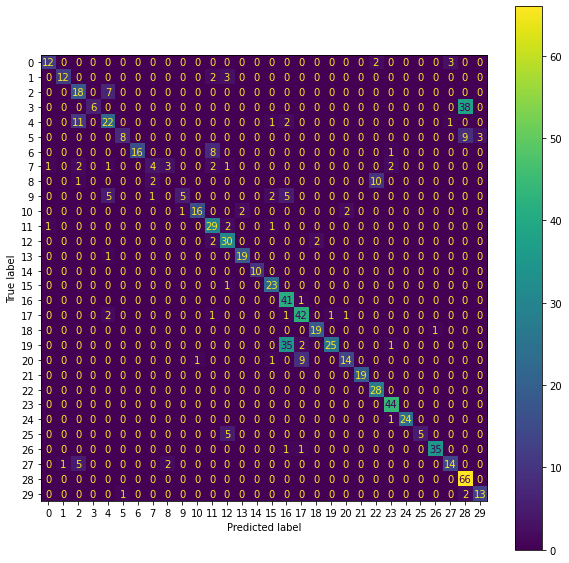

In [57]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10)  

Balanced accuracy score will be used as the leaderboard score.

In [56]:
balanced_accuracy_score(y_test, y_pred)

0.7158235028382088

This is the score to beat in this challenge.

## Submitting to the online challenge: [ramp.studio](https://ramp.studio) <a class="anchor" id="submitting"></a>

Once you found a good model, you can submit them to [ramp.studio](https://www.ramp.studio) to enter the online challenge. First, if it is your first time using the RAMP platform, [sign up](https://www.ramp.studio/sign_up), otherwise [log in](https://www.ramp.studio/login). Then sign up to the event [tephra](http://www.ramp.studio/events/tephra_datacamp2023). Both signups are controled by RAMP administrators, so there **can be a delay between asking for signup and being able to submit**.

Once your signup request is accepted, you can go to your [sandbox](https://www.ramp.studio/events/tephra_datacamp2023/sandbox) and copy-paste. You can also create a new folder `my_submission` in the `submissions` folder containing `classifier.py` and upload this file directly. You can check the starting-kit ([`classifier.py`](/edit/submissions/starting_kit/classifier.py)) for an example. The submission is trained and tested on our backend in the similar way as `ramp-test` does it locally. While your submission is waiting in the queue and being trained, you can find it in the "New submissions (pending training)" table in [my submissions](https://www.ramp.studio/events/tephra_datacamp2023/my_submissions). Once it is trained, your submission shows up on the [public leaderboard](https://www.ramp.studio/events/tephra_datacamp2023/leaderboard). 
If there is an error (despite having tested your submission locally with `ramp-test`), it will show up in the "Failed submissions" table in [my submissions](https://www.ramp.studio/events/tephra_datacamp2023/my_submissions). You can click on the error to see part of the trace.

The data set we use at the backend is usually different from what you find in the starting kit, so the score may be different.

The usual way to work with RAMP is to explore solutions, add feature transformations, select models, etc., _locally_, and checking them with `ramp-test`. The script prints mean cross-validation scores.

The official score in this RAMP (the first score column on the [leaderboard](http://www.ramp.studio/events/tephra_datacamp2023/leaderboard)) is the balenced accuracy score (`bal_acc`). When the score is good enough, you can submit it at the RAMP.

Here is the script proposed as the starting_kit:

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


class Classifier(BaseEstimator):
    def __init__(self):
        self.transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )
        self.model = LogisticRegression(max_iter=500)
        self.pipe = make_pipeline(self.transformer, self.model)

    def fit(self, X, y):
        self.pipe.fit(X, y)

    def predict(self, X):
        return self.pipe.predict(X)

    def predict_proba(self, X):
        return self.pipe.predict_proba(X)

You can test your solution locally by running the ramp-test command followed by --submission <my_submission folder>.
Here is an example with the starting_kit submission:

In [25]:
!ramp-test --submission starting_kit

Testing Volcanic events prediction from tephras
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
	score  bal_acc    acc      time
	train    0.833  0.864  1.809391
	valid    0.682  0.713  0.008721
	test     0.635  0.695  0.001404
CV fold 1
	score  bal_acc    acc      time
	train    0.826  0.879  1.175791
	valid    0.671  0.692  0.012650
	test     0.609  0.648  0.001484
----------------------------
Mean CV scores
----------------------------
	score         bal_acc             acc        time
	train  0.829 ± 0.0035  0.871 ± 0.0076  1.5 ± 0.32
	valid  0.676 ± 0.0055  0.703 ± 0.0103   0.0 ± 0.0
	test   0.622 ± 0.0129  0.672 ± 0.0232   0.0 ± 0.0
----------------------------
Bagged scores
----------------------------
	score  bal_acc    acc
	valid    0.625  0.703
	test     0.646  0.683


## More information

See the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html) for more details.

## Questions

Questions related to the starting kit should be asked on the [issue tracker](https://github.com/ramp-kits/tephra/issues).